**Setup and imports**

In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Dataset**

In [121]:
# Get project files
#!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
#!unzip cats_and_dogs.zip

PATH           = 'cats_and_dogs'
train_dir      = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir       = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 64
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

**Data preprocessing**
<p>Before we continue we have to preprocess image dataset. This means just applying some prior transformations to our data. In this case we'll simplyscale all our grayscale pixel value (0-255) to be between 0 and 1. We do this because smaller valueswill make it easier for our model to process our values.</p>
After you run the code, the output should look like this:
<ul>
<li>Found 2000 images belonging to 2 classes.</li>
    <li>Found 1000 images belonging to 2 classes.</li>
<li>Found 50 images belonging to 1 classes.</li>
</ul>

In [122]:
train_image_generator      = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator       = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=PATH+'/train',
    classes=['cats','dogs'],
    batch_size=batch_size,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='binary'
)
val_data_gen = validation_image_generator.flow_from_directory(
    directory=PATH+'/validation',
    classes=['cats','dogs'],
    batch_size=batch_size,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='binary'
)
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,
    classes=['test'],
    batch_size=batch_size,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=False,
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


<b>Data visualization utils</b>
<p>The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional.</p>

In [123]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

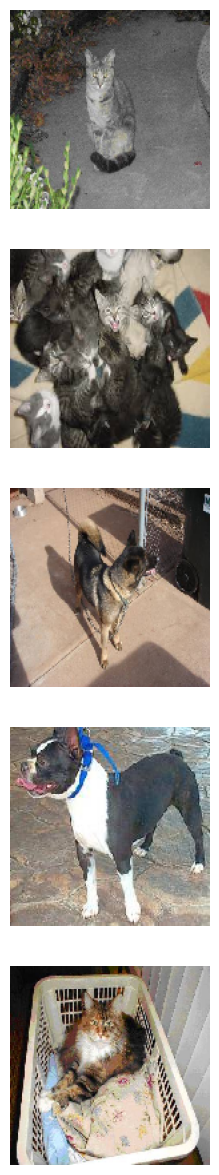

[0. 0. 1. 1. 0.]


In [124]:
sample_training_images, lab = next(train_data_gen)
plotImages(sample_training_images[:5])
print(lab[:5])

<b>Let increase our training dataset</b>

We recreate the `train_image_generator` using `ImageDataGenerator`. 
<p>
Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.
</p>

So we add 4-6 random transformations as arguments to `ImageDataGenerator`.


In [125]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    brightness_range=[0.8, 1.2],       # Random brightness adjustment
    width_shift_range=0.2,             # Random width shift
    height_shift_range=0.2,            # Random height shift
    fill_mode='nearest',               # Filling in missing pixels after transformation
    channel_shift_range=0.2,           # Random channel shifts
    preprocessing_function=None        # Add any custom preprocessing function if needed
)

Here `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


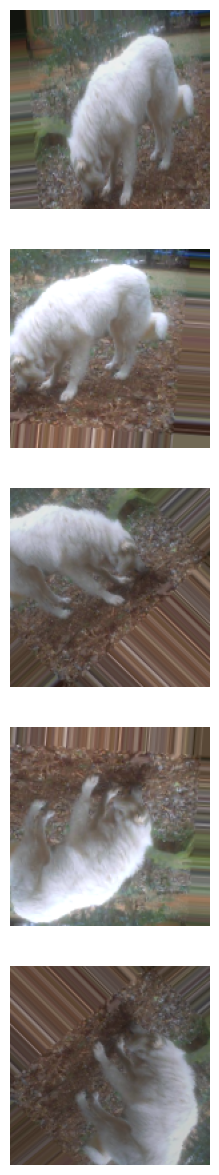

In [126]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Let get a look
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

<b>Building the model</b>

In [127]:
def build_model(name="FCC_CAT_DOT"):
    model = Sequential(name=name)
    model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    model.summary()
    return model

model = build_model()

Model: "FCC_CAT_DOT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,865 (9.39 MB)

 Trainable params: 2,460,865 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

**Training the model**

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [128]:
steps_per_epoch  = len(train_data_gen) // batch_size
validation_steps = len(val_data_gen) // batch_size

history = model.fit(train_data_gen, 
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch, 
    validation_data=val_data_gen, 
    validation_steps=validation_steps, 
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath="best_model.keras",
            monitor='val_loss', 
            verbose=0, 
            save_best_only=True, 
            save_weights_only=False
        )
    ])

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.5053 - loss: 0.7116 - val_accuracy: 0.5090 - val_loss: 0.6953
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 446ms/step - accuracy: 0.5146 - loss: 0.6894 - val_accuracy: 0.6420 - val_loss: 0.6449
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 432ms/step - accuracy: 0.5936 - loss: 0.6628 - val_accuracy: 0.6660 - val_loss: 0.6116
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step - accuracy: 0.5785 - loss: 0.6590 - val_accuracy: 0.6520 - val_loss: 0.6278
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 433ms/step - accuracy: 0.6424 - loss: 0.6320 - val_accuracy: 0.6910 - val_loss: 0.5898
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 438ms/step - accuracy: 0.6635 - loss: 0.6060 - val_accuracy: 0.6890 - val_loss: 0.5716
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 436ms/step - accuracy: 0.6583 - loss: 0.6011 - val_accuracy: 0.6850 - val_loss: 0.5706
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 434ms/step - accuracy: 0.6704 - loss: 0.6000 - val_accu

**Accuracy and loss of the model**

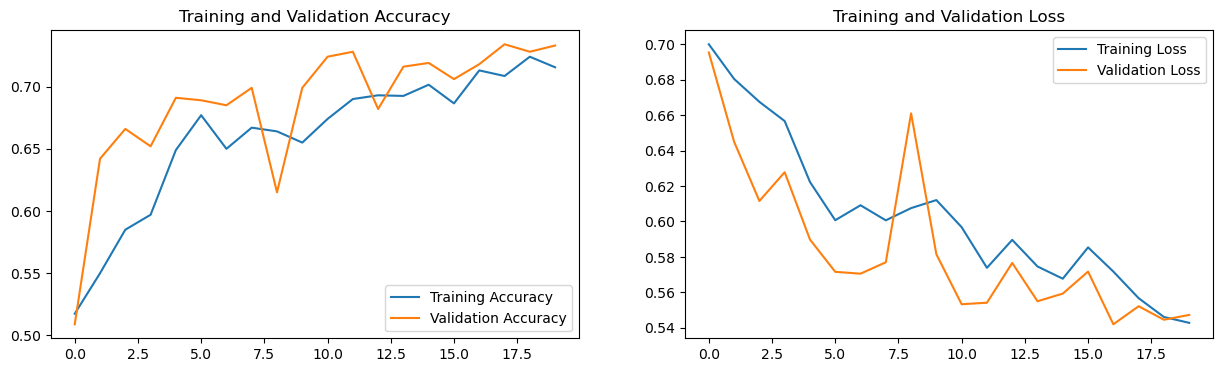

In [129]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<b>Prediction</b>

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


/var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T/ipykernel_3469/3019179878.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")
/var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T/ipykernel_3469/3019179878.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")


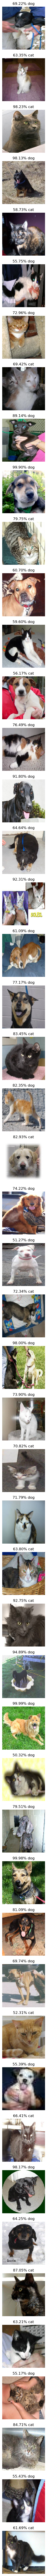

In [131]:
test_images, _ = next(test_data_gen)
probabilities = model.predict(test_data_gen)
plotImages(test_images, probabilities=probabilities)

<b>Final Assessment</b>

Run this final cell to see if you passed the challenge or if you need to keep trying.

In [132]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability[0]) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.72% of the images of cats and dogs.
You passed the challenge!
